In [1]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay
from keras.utils import plot_model
import pandas as pd
import seaborn as sns
import joblib
from pylab import rcParams

(40000, 14)


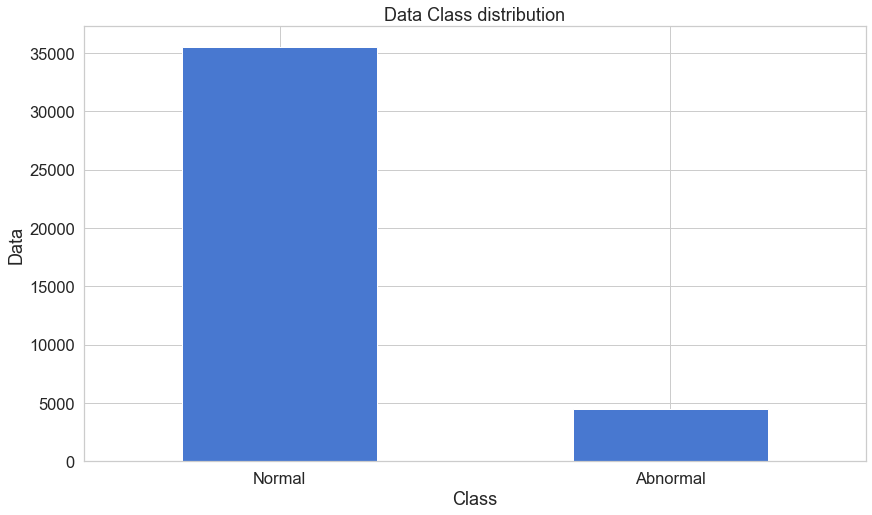

In [2]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder_wind.csv")  
print(df.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

In [3]:
X_train, X_test = train_test_split(data, test_size=0.5, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

# def normalize(label):
#     str = StandardScaler()
#     str.fit(X_train[label].values.reshape(-1, 1))
#     X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
#     X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

# def normalize1(label):
#     str = MinMaxScaler()
#     str.fit(X_train[label].values.reshape(-1, 1))
#     X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
#     X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

# A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

# for i in A:
#     normalize1(i)

def MinmaxNorm(data1, data2, label):
    for i in label:
        a = data1[i]
        b = data2[i]
        x_max = max(a)
        x_min = min(a)
        for j in list(range(a.shape[0])):
            a.iloc[j] = (a.iloc[j] - x_min) / (x_max - x_min)
        for k in list(range(b.shape[0])):
            b.iloc[k] = (b.iloc[k] - x_min) / (x_max - x_min)
    
    return data1, data2

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

X_train, X_test = MinmaxNorm(X_train, X_test, A)

# Add noise 
noise = 0.5
X_train_noisy = X_train + noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train = X_train.values
X_test = X_test.values

X_train_noisy = X_train_noisy.values
X_test_noisy = X_test_noisy.values

In [4]:
input_dim = 12
latent_dim = 4

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            # layers.Dense(8, activation='relu',
            #             activity_regularizer=regularizers.l2(10e-3)),
            layers.Dense(8, activation='sigmoid'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(input_dim, activation='relu'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
callback = EarlyStopping(monitor='val_loss', patience=3)
checkpointer = ModelCheckpoint(filepath="DAE_h8_l4",
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

batch_size = 12
nb_epochs = 100
history = autoencoder.fit(X_train_noisy, X_train,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.4,
                        callbacks=[checkpointer, tensorboard]).history

autoencoder.summary()

Epoch 1/100
889/889 [==============================] - 2s 2ms/step - loss: 0.1519 - val_loss: 0.1236
Epoch 2/100
889/889 [==============================] - 2s 2ms/step - loss: 0.1185 - val_loss: 0.0998
Epoch 3/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0979 - val_loss: 0.0974
Epoch 4/100
889/889 [==============================] - 1s 1ms/step - loss: 0.0972 - val_loss: 0.0974
Epoch 5/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0969 - val_loss: 0.0969
Epoch 6/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0965 - val_loss: 0.0967
Epoch 7/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0961 - val_loss: 0.0959
Epoch 8/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0957 - val_loss: 0.0958
Epoch 9/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0954 - val_loss: 0.0955
Epoch 10/100
889/889 [==============================] - 2s 2ms/step - loss: 0.0952 - val_lo

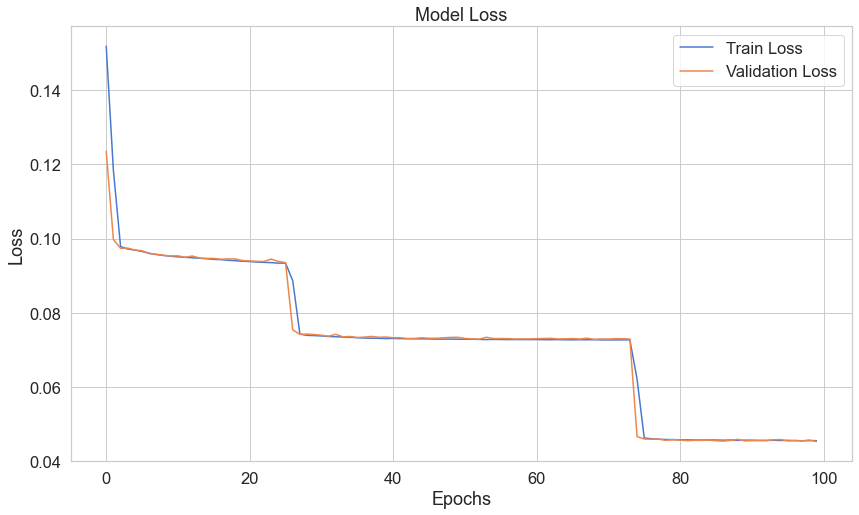

In [6]:
# 평가하기
plt.figure()
plt.plot(range(nb_epochs), history['loss'])
plt.plot(range(nb_epochs), history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right');
# plt.ylim([0, 1])
plt.show()

In [7]:
'''
오류 분포표
- 정밀도(Precision)
: 참인데 참이라고 예측한 데이터 / 참이라고 예측한 데이터
: 정상인데 정상이라고 예측한 데이터 / 정상이라고 예측한 데이터
- 재현율(Recall)
: 참인데 참이라고 예측한 데이터 / 실제로 참인 데이터
: 정상인테 정상이라고 예측한 데이터 / 실제로 정상인 데이터
'''
predictions1 = autoencoder.predict(X_train)
predictions2 = autoencoder.predict(X_test)
mse = np.mean(np.power((X_train - predictions1), 2), axis=1)
aver_rmse = np.mean(np.sqrt(mse), axis=0)
# thresholds = aver_rmse
thresholds = max(mse)
mse2 = np.mean(np.power((X_test - predictions2), 2), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse2,
                        'true_class': y_test})
# print(error_df.shape)
# error_df.describe()
error_df.reconstruction_error = error_df.reconstruction_error >= thresholds
error_df['reconstruction_error'] = error_df['reconstruction_error'].astype(int)
    
# print(error_df.shape[0])
print(error_df.reconstruction_error)
# print(error_df)

625/625 [==============================] - 0s 666us/step
32823    0
16298    0
28505    0
6689     1
26893    0
        ..
14965    0
22133    0
5442     0
21456    0
1760     0
Name: reconstruction_error, Length: 20000, dtype: int32


(0.0, 1.0)

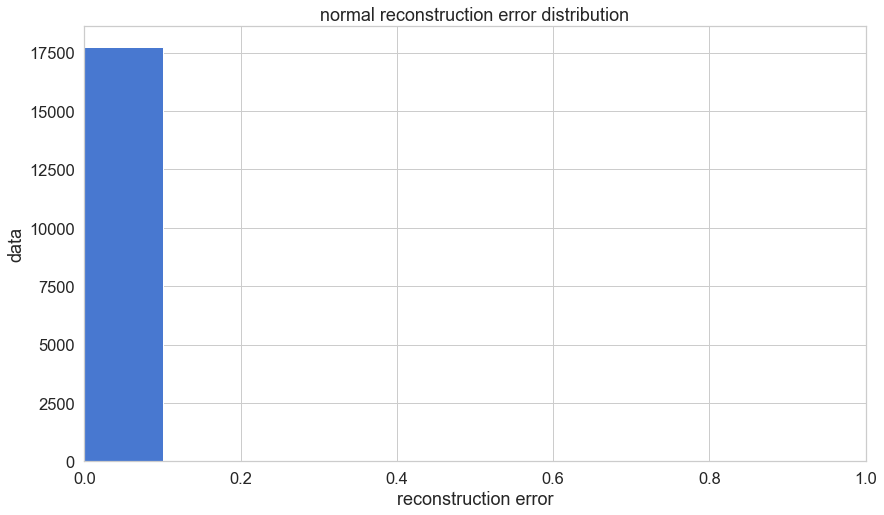

In [8]:
# 정상 거래 데이터들의 재구성 오류 분포
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
ax.set_title('normal reconstruction error distribution')
ax.set_xlabel('reconstruction error')
ax.set_ylabel('data')
ax.set_xlim([0, 1])

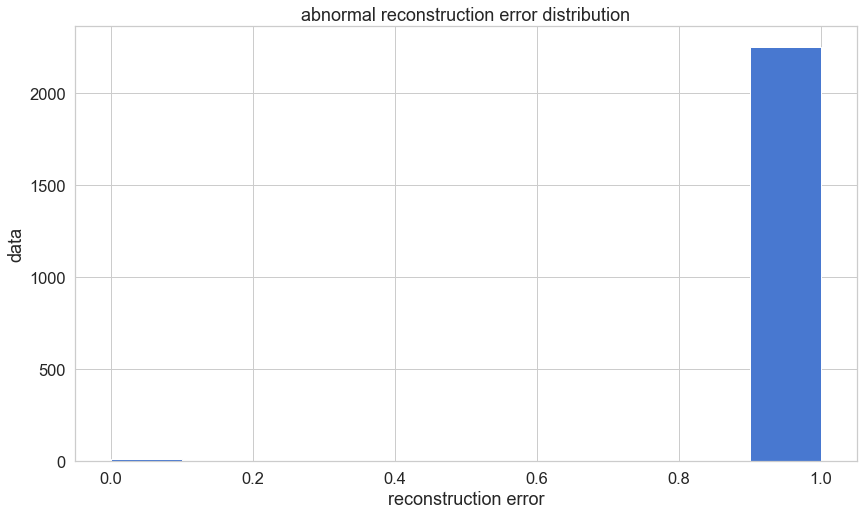

In [9]:
# 이상 거래 데이터들의 재구성 오류 분포
fig = plt.figure()
ax = fig.add_subplot(111)
Abnormal_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(Abnormal_error_df.reconstruction_error.values, bins=10)
ax.set_title('abnormal reconstruction error distribution')
ax.set_xlabel('reconstruction error')
ax.set_ylabel('data')
plt.show();

In [10]:
# ROC 곡선을 통한 평가
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
# ROC 곡선은 이진 분류기(binary classifier)의 성능을 평가하는 유용한 도구이다.
# 굉정히 불균형한 데이터셋을 가지고 있기 때문에 일반적인 경우가 아님
fpr, tpr, thresholds2 = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
F1_score = f1_score(error_df.true_class, error_df.reconstruction_error)
print(F1_score)

0.9966777408637874


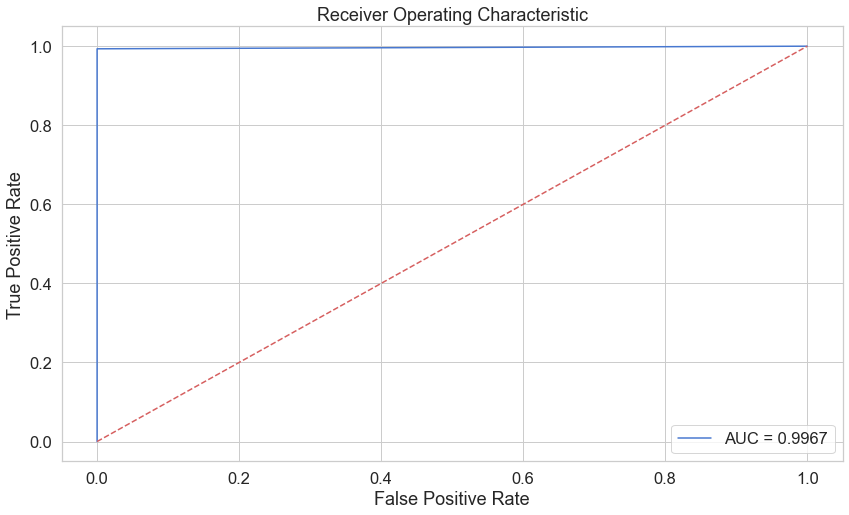

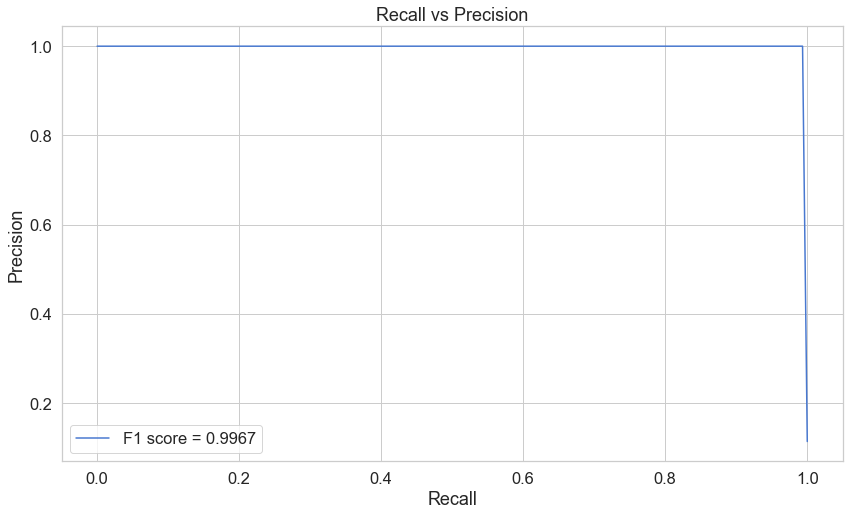

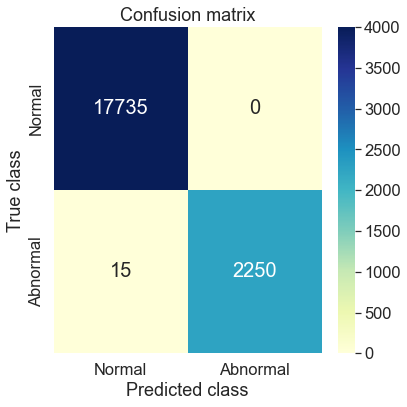

In [11]:
# ROC curve
plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.001, 1])
# plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# precision-recall curve
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='F1 score = %0.4f'% F1_score)
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show();

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, error_df.reconstruction_error)
LABELS = ["Normal", "Abnormal"]
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
                        annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
                        vmin=0, vmax=4000);
plt.title("Confusion matrix")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

In [12]:
# #
# predictions = autoencoder.predict(X_train)
# square_error1 = np.power((X_train - predictions), 2)
# groups = error_df.groupby('true_class')
# fig, ax = plt.subplots()

# for name, group in groups:
#     ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
#             label= "Abnormal" if name == 1 else "Normal")
# ax.hlines(thresholds, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
# ax.legend()
# plt.title("Reconstruction error for different classes")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.show();

# fig, ax = plt.subplots()

# for name, group in groups:
#     ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
#             label= "Abnormal" if name == 1 else "Normal")
# ax.hlines(thresholds, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
# ax.legend()
# plt.title("Reconstruction error for different classes")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.ylim([0, 10])
# plt.show();

# y_pred = [1 if e > thresholds else 0 for e in error_df.reconstruction_error.values]
# conf_matrix = confusion_matrix(error_df.true_class, y_pred)
# plt.figure(figsize=(12, 12))
# sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()